In [1]:
import numpy as np
import os
import random
import torch
from PIL import Image
import scipy.misc
from torchvision import datasets, transforms
from torch import nn
from torch.autograd import Variable
import torch.nn.init as init
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.autograd as autograd
import torchvision
import matplotlib as mpl
from tqdm import tqdm
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')
import torchvision.utils as vutils

%matplotlib inline

In [2]:
random.seed(1)
torch.manual_seed(1)
DATA_PATH='/media/bfortuner/bigguy/data/'
CUB_PATH=DATA_PATH+'cub/'
CUB_IMAGES_PATH=CUB_PATH+'images/'
MNIST_PATH=DATA_PATH+'mnist/'
MNIST_WEIGHTS_PATH=MNIST_PATH+'weights/'
MNIST_RESULTS_PATH='results/'

In [3]:
MNIST_BATCH_SIZE = 128
MNIST_MEAN = np.array([0.1307,])
MNIST_STD = np.array([0.3081,])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(MNIST_MEAN, MNIST_STD)
                   ])),
    batch_size=MNIST_BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(MNIST_MEAN, MNIST_STD)
                   ])),
    batch_size=MNIST_BATCH_SIZE, shuffle=True)

In [4]:
def plot_mnist(arr, title=None):
    """If normalized with mean/std"""
    if type(arr) is not np.ndarray:
        arr = arr.numpy().transpose((1, 2, 0))
    arr = denorm_meanstd(arr, MNIST_MEAN, MNIST_STD)
    arr = arr.reshape((28, 28))
    plt.imshow(arr, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.axis('off')
    plt.show()

def plot_samples(arr, dim=(4,4), figsize=(6,6)):
    if type(arr) is not np.ndarray:
        arr = arr.numpy()
    bs = arr.shape[0]
    arr = arr.reshape(bs, 28, 28)
    plt.figure(figsize=figsize)
    for i,img in enumerate(arr):
        plt.subplot(*dim, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

In [5]:
inputs,labels = next(iter(train_loader))
print(inputs.size())

torch.Size([128, 1, 28, 28])


In [6]:
# Use the 1,28,28 MNIST images 

def get_noise(batch_size, vec_size):
    return Variable(torch.FloatTensor(
        batch_size, vec_size, 1, 1).normal_(0,1).cuda())
    
def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        init.normal(m.weight.data, mean=0, std=0.2)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal(m.weight.data, mean=1, std=0.2)
        m.bias.data.zero_()

class G_Block(nn.Sequential):
    def __init__(self, in_chans, out_chans, f_size, stride, pad):
        super(G_Block, self).__init__()
        self.convTrans = nn.ConvTranspose2d(
            in_chans, out_chans, f_size, stride, pad, bias=False)
        self.batchNorm = nn.BatchNorm2d(out_chans)
        self.ReLU = nn.ReLU(True)

class netG(nn.Module):
    def __init__(self, in_chans, out_chans):
        super(netG, self).__init__()
        self.block1 = G_Block(in_chans+1, 256, 7, stride=1, pad=0)
        self.block2 = G_Block(256, 128, 4, stride=2, pad=1)
#         self.block3 = G_Block(256, 128, 4, stride=2, pad=1)
#         self.block4 = G_Block(128, 64, 4, stride=2, pad=1)
        self.convTrans = nn.ConvTranspose2d(
            128, out_chans, 4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, y):
        #print(x.size(),y.size())
        y = y.view(y.size(0), 1, 1, 1)
        #print(x.size(),y.size())
        out = torch.cat([x, y], 1)
        #print (out.size())
        out = self.block1(out)
        #print(out.size())
        out = self.block2(out)
        #print(out.size())
#         out = self.block3(out)
#         print(out.size())
#         out = self.block4(out)
#         print(out.size())
        out = self.convTrans(out)
        #print(out.size())
        out = self.tanh(out)
        return out

class D_Block(nn.Sequential):
    def __init__(self, in_chans, out_chans, f_size, stride, pad, bn=True):
        super(D_Block, self).__init__()
        self.conv = nn.Conv2d(
            in_chans, out_chans, f_size, stride, pad, bias=False)
        if bn:
            self.bn = nn.BatchNorm2d(out_chans)
        self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

class netD(nn.Module):
    def __init__(self, in_chans):
        super(netD, self).__init__()
        self.block1 = D_Block(in_chans+1, 64, 4, stride=2, pad=1, bn=False)
        self.block2 = D_Block(64, 128, 4, stride=2, pad=1)
        self.block3 = D_Block(128, 256, 4, stride=2, pad=1)
        #self.block4 = D_Block(256, 512, 4, stride=2, pad=1)
        self.conv = nn.Conv2d(256, 1, 3, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        bs,ch,w,h = x.size()
        y = y.view(bs, 1, 1, 1)
        y = y.expand(bs,ch,w,h)
        #print (x.size(), y.size())
        out = torch.cat([x,y], 1)
        #print(out.size())
        out = self.block1(out)
        #print(out.size())
        out = self.block2(out)
        #print(out.size())
        out = self.block3(out)
        #print(out.size())
        #out = self.block4(out)
        #print(out.size())
        out = self.conv(out)
        #print(out.size())
        out = self.sigmoid(out)
        return out.view(-1,1)

In [7]:
cudnn.benchmark = True

noise_vec_size = 100 #input to generator

D = netD(1).cuda()
G = netG(noise_vec_size, 1).cuda()
D.apply(weights_init)
G.apply(weights_init)

# both are evaluated with a 1/0 answer from discriminator
criterion = nn.BCELoss().cuda() 
D_optimizer = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

fixed_noise = Variable(torch.FloatTensor(
    MNIST_BATCH_SIZE, noise_vec_size, 1, 1).normal_(0,1).cuda())
real_labels = Variable(torch.ones(MNIST_BATCH_SIZE, 1).cuda())
fake_labels = Variable(torch.zeros(MNIST_BATCH_SIZE, 1).cuda())

In [9]:
def train(G, D, criterion, G_optim, D_optim, dataloader, epochs):
    n_batches = len(dataloader)
    D_total_loss = 0
    G_total_loss = 0
    for inputs,targets in train_loader:
        batch_size = inputs.size(0)
        real_imgs = Variable(inputs.cuda())
        class_names = Variable(targets.float().cuda())
        
        # Clear gradients
        D.zero_grad()
        G.zero_grad()
        
        ## Discriminator - Real
        D_real_out = D(real_imgs, class_names)
        D_real_loss = criterion(D_real_out, real_labels[:batch_size])
        D_real_loss.backward()
        
        ## Discriminator - Fake
        noise = get_noise(batch_size, noise_vec_size)
        D_fake_out = D(G(noise, class_names).detach(), class_names)
        D_fake_loss = criterion(D_fake_out, fake_labels[:batch_size])

        D_fake_loss.backward()
        D_optim.step()
        
        D_loss = D_real_loss + D_fake_loss
        
        ## Generator
        G_out = D(G(noise, class_names), class_names)
        G_loss = criterion(G_out, real_labels[:batch_size])
        
        G_loss.backward()
        G_optim.step()
        
        D_total_loss += D_loss.data[0] / n_batches
        G_total_loss += G_loss.data[0] / n_batches
        
    # do checkpointing
    torch.save(D.state_dict(), '%sD_mnist_cgan_%03d.pth' % (MNIST_WEIGHTS_PATH, epoch))
    torch.save(G.state_dict(), '%sG_mnist_cgan_%03d.pth' % (MNIST_WEIGHTS_PATH, epoch))
    return D_total_loss, G_total_loss

def test(G, class_name, out_path, n_samples, epoch=1):
    class_labels = Variable(torch.FloatTensor(n_samples).fill_(class_name).cuda())
    fake = G(fixed_noise[:n_samples], class_labels)
    vutils.save_image(fake.data.cpu(),
            '%s/fake_samples_cgan_epoch_%03d.png' % (out_path, epoch),
            normalize=True)
    return fake.data.cpu()

def plot_fake_samples(G, class_name, n_samples=12):
    class_labels = Variable(torch.FloatTensor(n_samples).fill_(class_name).cuda())
    fake = G(fixed_noise[:n_samples], class_labels).data.cpu()
    plot_samples(fake)

In [10]:
EPOCHS=2
TEST_DIGIT = 5

In [11]:
loss_history = []
for epoch in tqdm(range(1,EPOCHS+1)):
    D_loss, G_loss = train(G, D, criterion, G_optimizer, D_optimizer, train_loader, epoch)
    loss_history.append([D_loss, G_loss])
    fake_samples = test(G, TEST_DIGIT, MNIST_RESULTS_PATH, 16, epoch)

100%|██████████| 2/2 [01:48<00:00, 71.03s/it]


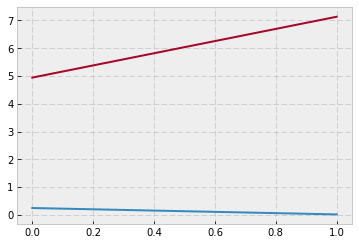

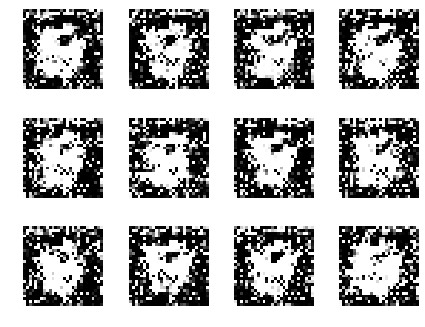

In [12]:
loss_history = np.array(loss_history)
plt.plot(loss_history[:,0]) #D_loss
plt.plot(loss_history[:,1]) #G_loss
plot_fake_samples(G, TEST_DIGIT)

In [43]:
D.load_state_dict(torch.load(MNIST_WEIGHTS_PATH+'D_mnist_cgan_020.pth'))
G.load_state_dict(torch.load(MNIST_WEIGHTS_PATH+'G_mnist_cgan_020.pth'))

In [46]:
START_EPOCH=21
END_EPOCH=START_EPOCH+50

loss_history = []
for epoch in tqdm(range(START_EPOCH, END_EPOCH)):
    D_loss, G_loss = train(G, D, criterion, G_optimizer, D_optimizer, train_loader, epoch)
    loss_history.append([D_loss, G_loss])
    fake_samples = test(G, TEST_DIGIT, MNIST_RESULTS_PATH, 16, epoch)


100%|██████████| 50/50 [43:10<00:00, 51.98s/it]


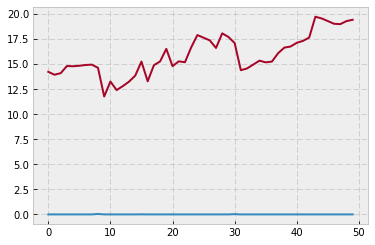

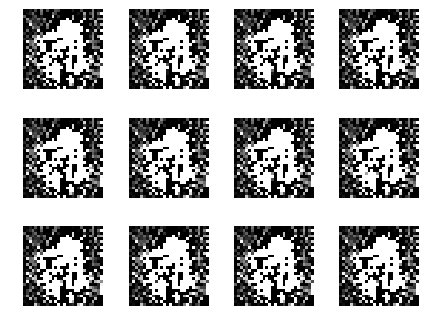

In [47]:
loss_history = np.array(loss_history)
plt.plot(loss_history[:,0]) #D_loss
plt.plot(loss_history[:,1]) #G_loss
plot_fake_samples(G, TEST_DIGIT)